# Trial segmentation script

This notebook is intended for the breakdown, classification and analysis of the behavioural states shown in the video, starting from a trial segmentation. 

In [14]:
#uncomment and run if there are issues with the version of the dependencies
#  %pip uninstall -y pandas numpy
# %pip install --upgrade --force-reinstall "numpy<2"
# %pip install --upgrade --force-reinstall opencv-python
# %pip install pandas

- `trial segmentation` takes the output of simplerCode.py (video + .csv), and segments the video based on mouse entry and exit times in the video rather than the .csv
- we then will manually sort the trials into `exploitative`, `explorative` and `nest`
- extract speed and trajectories per trial
- identify behavioural syllables with keypoint moseq 2D



In [15]:
# %pip install -q numpy pandas opencv-python

import os
from pathlib import Path
from typing import List, Tuple, Optional, Dict
import numpy as np
import pandas as pd
import cv2 as cv


create a csv to video dictionary with the mice and trials we are interested in 

In [18]:
main_dir = "C:/Users/aleja/Box/Awake Project/Maze data/simplermaze/"

#this is where the csv files of interest are stored
csvs = []

#this is where we store the videos
videos = []


for i in os.listdir(main_dir):
    if "6357" in i or "6359" in i:
        mouse_dir = os.path.join(main_dir, i)
        # print(mouse_dir[-10:])
        for session in os.listdir(mouse_dir):
            if 'habituation' in session or '1.1' in session or "3.5" in session or "3.6" in session or "3.7" in session or "3.8" in session:
                session_dir = os.path.join(mouse_dir, session)
                # print(f"    -{session_dir[-10:]}")

                for file in os.listdir(session_dir):

                    full_path_file = os.path.join(session_dir, file)

                    if "trial_info.csv" in file and "clean" not in file:
                        csvs.append(full_path_file)
                        # print(f"        -{file}")
                    elif "mp4" in file:
                        videos.append(full_path_file)

csv_video = dict(zip(csvs, videos))

for key,value in csv_video.items():

    key= os.path.basename(key)
    value = os.path.basename(value)

    print(f"{key}  :  {value}")


mouse6357_session3.5_trial_info.csv  :  6357_2024-08-27_13_05_19s3.5.mp4
mouse6357_session3.6_trial_info.csv  :  6357_2024-08-28_11_58_14s3.6.mp4
mouse6357_session3.7_trial_info.csv  :  6357_2024-08-29_10_23_02s3.7.mp4
mouse6357_session3.8_trial_info.csv  :  6357_2024-08-30_10_07_55s3.8.mp4
mouse6357_session1.1_trial_info.csv  :  6357_2024-08-15_11_23_10.mp4
mouse6359_session3.5_trial_info.csv  :  6359_2024-08-27_14_08_35s3.5.mp4
mouse6359_session3.6_trial_info.csv  :  6359_2024-08-28_13_28_27s3.6.mp4
mouse6359_session3.7_trial_info.csv  :  6359_2024-08-29_11_39_28s3.7.mp4
mouse6359_session3.8_trial_info.csv  :  6359_2024-08-30_11_28_10s3.8.mp4
mouse6359_session1.1_trial_info.csv  :  6359_2024-08-15_14_05_08.mp4


in this notebook we will select the rois in the first frame of the first video, and they will become the reference rois. We then use homography to adapt the rois to the other videos, and have the option of accepting/redrawing/skipping. 

In [17]:
# === EDIT THIS to where you want the reference ROI CSV saved ===
REF_ROIS_CSV = main_dir + "rois_reference.csv" # <- put your desired path here

# the ordered ROI names you’ll draw on the first (reference) video
ROI_NAMES = ["entrance1", "entrance2"]

# homography scale for feature matching (smaller = faster; 0.5–0.8 is a good range)
PYR_SCALE = 0.75


In [18]:
def open_video_any(path: str):
    for backend in (cv.CAP_MSMF, cv.CAP_FFMPEG, cv.CAP_DSHOW, cv.CAP_ANY):
        cap = cv.VideoCapture(path, backend)
        ok, frame = cap.read()
        if ok and frame is not None:
            cap.set(cv.CAP_PROP_POS_FRAMES, 0)
            return cap
        try: cap.release()
        except Exception: pass
    return None

def grab_first_frame(video_path: str) -> Optional[np.ndarray]:
    cap = open_video_any(video_path)
    if cap is None:
        return None
    ok, frame = cap.read()
    cap.release()
    return frame if ok else None

def save_rois_csv(dest_csv: Path, rows: List[Tuple[str,int,int,int,int]]) -> None:
    df = pd.DataFrame(rows, columns=["name","x","y","w","h"])
    dest_csv.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(dest_csv, index=False)

def load_rois_long(csv_path: str) -> List[Tuple[str,int,int,int,int]]:
    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    need = {"name","x","y","w","h"}
    if not need.issubset(df.columns):
        raise ValueError(f"ROI CSV must have columns {need}; got {set(df.columns)}")
    out = []
    for name, x, y, w, h in df[["name","x","y","w","h"]].itertuples(index=False, name=None):
        out.append((str(name).lower(), int(x), int(y), int(w), int(h)))
    return out

def overlay_rois(image: np.ndarray, rows: List[Tuple[str,int,int,int,int]], color=(0,255,0)) -> np.ndarray:
    out = image.copy()
    for name, x, y, w, h in rows:
        cv.rectangle(out, (x, y), (x+w, y+h), color, 2)
        cv.putText(out, name, (x, max(20, y-10)), cv.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv.LINE_AA)
    return out

def draw_rois_on_first_frame(video_path: str, roi_names=ROI_NAMES, scale: float = 2.0
                             ) -> List[Tuple[str,int,int,int,int]]:
    """
    Interactively draw the ROIs in the order given by roi_names.
    Returns [(name,x,y,w,h)] in original-resolution coordinates.
    """
    frame = grab_first_frame(video_path)
    if frame is None:
        raise RuntimeError(f"Could not open/read: {video_path}")

    disp = cv.resize(frame, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
    win = "Draw ROIs - ENTER to confirm, ESC to skip"
    cv.namedWindow(win, cv.WINDOW_NORMAL)
    cv.resizeWindow(win, disp.shape[1], disp.shape[0])
    try:
        cv.setWindowProperty(win, cv.WND_PROP_TOPMOST, 1)
    except Exception:
        pass

    selections: List[Tuple[str,int,int,int,int]] = []
    overlays: List[Tuple[str,int,int,int,int]] = []

    for name in roi_names:
        frame_show = disp.copy()
        for nm, sx, sy, sw, sh in overlays:
            cv.rectangle(frame_show, (sx, sy), (sx+sw, sy+sh), (255,0,0), 2)
            cv.putText(frame_show, nm, (sx, max(20, sy-10)), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv.LINE_AA)
        cv.putText(frame_show, f"Draw {name} then ENTER (ESC to skip)", (20, 40),
                   cv.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,255), 3, cv.LINE_AA)

        r = cv.selectROI(win, frame_show, fromCenter=False, showCrosshair=True)
        if r == (0,0,0,0):
            print(f"[WARN] Skipped ROI: {name}")
            continue
        x = int(r[0] / scale); y = int(r[1] / scale)
        w = int(r[2] / scale); h = int(r[3] / scale)
        selections.append((name.lower(), x, y, w, h))
        overlays.append((name, r[0], r[1], r[2], r[3]))

    cv.destroyAllWindows()
    if not selections:
        raise RuntimeError("No ROIs were drawn.")
    return selections

# --- homography (ORB + BFMatcher + RANSAC) ---
def detect_homography(ref_img: np.ndarray, cur_img: np.ndarray) -> Optional[np.ndarray]:
    g1 = cv.cvtColor(ref_img, cv.COLOR_BGR2GRAY) if ref_img.ndim == 3 else ref_img
    g2 = cv.cvtColor(cur_img, cv.COLOR_BGR2GRAY) if cur_img.ndim == 3 else cur_img
    orb = cv.ORB_create(nfeatures=5000, scaleFactor=1.2, edgeThreshold=15, patchSize=31)
    k1, d1 = orb.detectAndCompute(g1, None)
    k2, d2 = orb.detectAndCompute(g2, None)
    if d1 is None or d2 is None or len(k1) < 20 or len(k2) < 20:
        return None
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(d1, d2)
    if len(matches) < 20:
        return None
    matches = sorted(matches, key=lambda m: m.distance)[:500]
    src = np.float32([k1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst = np.float32([k2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, mask = cv.findHomography(src, dst, cv.RANSAC, 3.0)
    if H is None: return None
    if mask is not None and int(mask.sum()) < 20:
        return None
    return H

def project_rect(x: int, y: int, w: int, h: int, H: np.ndarray) -> Tuple[int,int,int,int]:
    pts = np.array([[x,y], [x+w,y], [x+w,y+h], [x,y+h]], dtype=np.float32).reshape(-1,1,2)
    proj = cv.perspectiveTransform(pts, H).reshape(-1,2)
    xs, ys = proj[:,0], proj[:,1]
    x0 = max(0, int(np.floor(xs.min()))); y0 = max(0, int(np.floor(ys.min())))
    x1 = int(np.ceil(xs.max())); y1 = int(np.ceil(ys.max()))
    return x0, y0, max(1, x1-x0), max(1, y1-y0)

def auto_rois_from_reference(cur_img: np.ndarray,
                             ref_img: np.ndarray,
                             ref_rows: List[Tuple[str,int,int,int,int]],
                             pyr_scale: float = 0.75) -> Optional[List[Tuple[str,int,int,int,int]]]:
    """
    Estimate homography (optionally on downscaled images) and map ref ROIs -> current frame.
    """
    if pyr_scale != 1.0:
        def S(a): return np.array([[a,0,0],[0,a,0],[0,0,1]], dtype=np.float32)
        ref_s = cv.resize(ref_img, None, fx=pyr_scale, fy=pyr_scale)
        cur_s = cv.resize(cur_img, None, fx=pyr_scale, fy=pyr_scale)
        Hs = detect_homography(ref_s, cur_s)
        if Hs is None: return None
        H = np.linalg.inv(S(pyr_scale)) @ Hs @ S(pyr_scale)
    else:
        H = detect_homography(ref_img, cur_img)
        if H is None: return None

    out = []
    for name, x, y, w, h in ref_rows:
        x2, y2, w2, h2 = project_rect(x, y, w, h, H)
        out.append((name, x2, y2, w2, h2))
    return out


In [19]:
# Your code that builds csv_video should already have run.
# csv_video maps: trial_csv_path -> video_path
assert isinstance(csv_video, dict) and len(csv_video) > 0, "csv_video is empty"
print("Found pairs:", len(csv_video))


Found pairs: 10


commenting roi selection for reference video out so that we don't reprocess stuff for now

In [ ]:
# # pick the first (CSV -> VIDEO) pair from your dict
# first_csv, first_video = next(iter(csv_video.items()))
# print("Reference video:", first_video)

# # draw interactively on the first video
# ref_rows = draw_rois_on_first_frame(first_video, roi_names=ROI_NAMES, scale=2.0)
# save_rois_csv(Path(REF_ROIS_CSV), ref_rows)
# print("Saved reference ROIs ->", REF_ROIS_CSV)
# #
# # (optional) quick visual check
# frame0 = grab_first_frame(first_video)
# vis0 = overlay_rois(frame0, ref_rows)
# cv.imshow("Reference ROIs (press any key to close)", vis0); cv.waitKey(0); cv.destroyAllWindows()


Reference video: C:/Users/shahd/Box/Awake Project/Maze data/simplermaze/mouse 6357\2024-08-27_13_05_196357session3.5\6357_2024-08-27_13_05_19s3.5.mp4
Saved reference ROIs -> C:/Users/shahd/Box/Awake Project/Maze data/simplermaze/rois_reference.csv


This iterates over all the other videos in csv_video, adapts the ROIs via homography, shows you a quick preview `(Y=accept, R=redraw, Q=skip)`, and saves a per-video ROI file named "<video_stem>_rois.csv" next to each video.

also commenting this out for now so that we don't redraw the rois

In [ ]:
# ref_frame = grab_first_frame(first_video)
# ref_rows  = load_rois_long(REF_ROIS_CSV)

# adapted_summary = []

# for trials_csv, video in csv_video.items():
#     if video == first_video:
#         # skip the reference; it's already drawn and saved
#         continue

#     vp = Path(video).resolve()
#     out_csv = vp.with_suffix("").as_posix() + "_rois.csv"

#     cur_frame = grab_first_frame(str(vp))
#     if cur_frame is None:
#         print(f"[SKIP] Cannot open video: {vp}")
#         continue

#     # try homography-based transfer
#     adapted = auto_rois_from_reference(cur_frame, ref_frame, ref_rows, pyr_scale=PYR_SCALE)

#     # preview: Y=accept, R=manual redraw, Q=skip
#     if adapted is not None:
#         preview = overlay_rois(cur_frame, adapted, color=(0,255,0))
#     else:
#         preview = overlay_rois(cur_frame, ref_rows, color=(0,255,255))  # fallback preview

#     win = f"Adapted ROIs: {vp.name}  [Y=accept | R=redraw | Q=skip]"
#     cv.namedWindow(win, cv.WINDOW_NORMAL)
#     cv.imshow(win, preview)
#     key = cv.waitKey(0) & 0xFF
#     cv.destroyAllWindows()

#     if key in (ord('y'), ord('Y')) and adapted is not None:
#         rows = adapted
#         reason = "accepted_adapted"
#     elif key in (ord('r'), ord('R')):
#         print("Manual redraw...")
#         rows = draw_rois_on_first_frame(str(vp), roi_names=[n for n, *_ in ref_rows], scale=2.0)
#         reason = "redrawn_manual"
#     elif key in (ord('q'), ord('Q')):
#         print(f"[SKIP] user skipped: {vp.name}")
#         continue
#     else:
#         # default fallback: if adaptation failed and not redrawn, use reference ROIs
#         rows = adapted if adapted is not None else ref_rows
#         reason = "fallback_to_reference" if adapted is None else "accepted_adapted_default"

#     save_rois_csv(Path(out_csv), rows)
#     print(f"Saved ROIs -> {out_csv}  ({reason})")
#     adapted_summary.append({"video": str(vp), "roi_csv": out_csv, "how": reason})

# pd.DataFrame(adapted_summary)


Manual redraw...
Saved ROIs -> C:/Users/shahd/Box/Awake Project/Maze data/simplermaze/mouse 6357/2024-08-28_11_58_146357session3.6/6357_2024-08-28_11_58_14s3.6_rois.csv  (redrawn_manual)
Manual redraw...
Saved ROIs -> C:/Users/shahd/Box/Awake Project/Maze data/simplermaze/mouse 6357/2024-08-29_10_23_026357session3.7/6357_2024-08-29_10_23_02s3.7_rois.csv  (redrawn_manual)
Manual redraw...
Saved ROIs -> C:/Users/shahd/Box/Awake Project/Maze data/simplermaze/mouse 6357/2024-08-30_10_07_556357session3.8/6357_2024-08-30_10_07_55s3.8_rois.csv  (redrawn_manual)
Manual redraw...
Saved ROIs -> C:/Users/shahd/Box/Awake Project/Maze data/simplermaze/mouse 6357/habituation/6357_2024-08-15_11_23_10_rois.csv  (redrawn_manual)
Manual redraw...
Saved ROIs -> C:/Users/shahd/Box/Awake Project/Maze data/simplermaze/mouse 6359/2024-08-27_14_08_356359session3.5/6359_2024-08-27_14_08_35s3.5_rois.csv  (redrawn_manual)
Manual redraw...
Saved ROIs -> C:/Users/shahd/Box/Awake Project/Maze data/simplermaze/mouse

,video,roi_csv,how
0,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:/Users/shahd/Box/Awake Project/Maze data/sim...,redrawn_manual
1,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:/Users/shahd/Box/Awake Project/Maze data/sim...,redrawn_manual
2,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:/Users/shahd/Box/Awake Project/Maze data/sim...,redrawn_manual
3,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:/Users/shahd/Box/Awake Project/Maze data/sim...,redrawn_manual
4,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:/Users/shahd/Box/Awake Project/Maze data/sim...,redrawn_manual
5,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:/Users/shahd/Box/Awake Project/Maze data/sim...,redrawn_manual
6,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:/Users/shahd/Box/Awake Project/Maze data/sim...,redrawn_manual
7,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:/Users/shahd/Box/Awake Project/Maze data/sim...,redrawn_manual
8,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:/Users/shahd/Box/Awake Project/Maze data/sim...,redrawn_manual


In [22]:
# Install & point to a working ffmpeg binary for THIS kernel
%pip install -q imageio-ffmpeg

import os, imageio_ffmpeg, shutil, subprocess
os.environ["IMAGEIO_FFMPEG_EXE"] = imageio_ffmpeg.get_ffmpeg_exe()
print("Using ffmpeg at:", os.environ["IMAGEIO_FFMPEG_EXE"])

# sanity check
subprocess.run([os.environ["IMAGEIO_FFMPEG_EXE"], "-version"], check=True)


Note: you may need to restart the kernel to use updated packages.
Using ffmpeg at: c:\Users\shahd\OneDrive\Documents\GitHub\mice-maze\.venv\lib\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe


CompletedProcess(args=['c:\\Users\\shahd\\OneDrive\\Documents\\GitHub\\mice-maze\\.venv\\lib\\site-packages\\imageio_ffmpeg\\binaries\\ffmpeg-win-x86_64-v7.1.exe', '-version'], returncode=0)

This script relies on the rois.csv for every video to segment the trials based on the same logic of simplermaze (left e2 after e1 == entered maze == trial starts; ledt e1 after e2 == left maze == trial ends)

In [23]:
import os, shutil, subprocess
from pathlib import Path
from typing import Dict
import numpy as np
import pandas as pd
import cv2 as cv

# ---------- ffmpeg ----------
def ffmpeg_bin():
    return os.environ.get("IMAGEIO_FFMPEG_EXE") or "ffmpeg"

def ensure_ffmpeg():
    exe = ffmpeg_bin()
    ok = (Path(exe).exists() if (":" in exe or exe.endswith(".exe")) else shutil.which(exe) is not None)
    if not ok:
        raise RuntimeError(f"ffmpeg not found at '{exe}'. Install ffmpeg or set IMAGEIO_FFMPEG_EXE.")

# ---------- small utils ----------
def _grab(frame, r):
    return frame[r["ystart"]:r["ystart"]+r["ylen"], r["xstart"]:r["xstart"]+r["xlen"]]

def compute_roi_baselines(cap, rois: Dict[str,Dict[str,int]], num_frames=10, thresh_value=160):
    thresholds = {k: 0.0 for k in rois}; n = 0
    pos = int(cap.get(cv.CAP_PROP_POS_FRAMES))
    for _ in range(num_frames):
        ok, frame = cap.read()
        if not ok: break
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) if frame.ndim == 3 else frame
        _, bw = cv.threshold(gray, thresh_value, 255, cv.THRESH_BINARY)
        for name, rect in rois.items():
            thresholds[name] += float(np.sum(_grab(bw, rect)))
        n += 1
    cap.set(cv.CAP_PROP_POS_FRAMES, pos)
    if n == 0:
        raise RuntimeError("Could not read frames to compute baselines.")
    for k in thresholds: thresholds[k] /= n
    return thresholds

def detect_bouts_by_entrances(
    video_path: str,
    rois_csv: str,
    thresh_value: int = 160,
    threshold_factor: float = 0.5,
    min_duration_s: float = 0.4,
    merge_gap_s: float = 0.2,
):
    """
    Build bouts using entrance logic:
      - leave entrance1 then leave entrance2  => ENTER
      - leave entrance2 then leave entrance1  => EXIT
    """
    df = pd.read_csv(rois_csv)
    df.columns = [c.lower() for c in df.columns]
    rois = {str(n).lower(): {"xstart":int(x), "ystart":int(y), "xlen":int(w), "ylen":int(h)}
            for n,x,y,w,h in df[["name","x","y","w","h"]].itertuples(index=False, name=None)}
    if "entrance1" not in rois or "entrance2" not in rois:
        raise ValueError("ROIs must include 'entrance1' and 'entrance2'.")

    # open video
    for backend in (cv.CAP_MSMF, cv.CAP_FFMPEG, cv.CAP_DSHOW, cv.CAP_ANY):
        cap = cv.VideoCapture(str(video_path), backend)
        ok, _ = cap.read()
        if ok: 
            cap.set(cv.CAP_PROP_POS_FRAMES, 0)
            break
        try: cap.release()
        except: pass
        cap = None
    if cap is None:
        raise FileNotFoundError(f"Cannot open video: {video_path}")

    fps = cap.get(cv.CAP_PROP_FPS) or 0.0
    if fps <= 1e-3: fps = 30.0
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) or None

    baselines = compute_roi_baselines(cap, rois, num_frames=10, thresh_value=thresh_value)
    def occupied(bw, name):
        return (np.sum(_grab(bw, rois[name])) < baselines[name] * threshold_factor)

    ent1_prev = False; ent2_prev = False
    hasLeft1 = False; hasLeft2 = False
    entered = False
    bouts = []
    cur_start = None

    frame_idx = 0
    cap.set(cv.CAP_PROP_POS_FRAMES, 0)
    while True:
        ok, frame = cap.read()
        if not ok: break
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) if frame.ndim == 3 else frame
        _, bw = cv.threshold(gray, thresh_value, 255, cv.THRESH_BINARY)

        e1_now = occupied(bw, "entrance1")
        e2_now = occupied(bw, "entrance2")

        left1 = (not e1_now) and ent1_prev
        left2 = (not e2_now) and ent2_prev

        if left1:
            hasLeft1 = True
            if hasLeft2 and entered:
                # EXIT (sequence 2->1)
                end_s = frame_idx / fps
                if cur_start is not None:
                    bouts.append((cur_start, end_s))
                cur_start = None
                entered = False
                hasLeft1 = hasLeft2 = False

        if left2:
            hasLeft2 = True
            if hasLeft1 and not entered:
                # ENTER (sequence 1->2)
                cur_start = frame_idx / fps
                entered = True

        ent1_prev, ent2_prev = e1_now, e2_now
        frame_idx += 1

    if entered and cur_start is not None:
        end_s = (total_frames / fps) if total_frames else (frame_idx / fps)
        bouts.append((cur_start, end_s))
    cap.release()

    # merge short gaps & drop tiny bouts
    if not bouts:
        return []
    merged = []
    s0, e0 = bouts[0]
    for s, e in bouts[1:]:
        if s - e0 <= merge_gap_s:
            e0 = e
        else:
            merged.append((s0, e0)); s0, e0 = s, e
    merged.append((s0, e0))
    return [(s, e) for (s, e) in merged if (e - s) >= min_duration_s]

def cut_segment_ffmpeg(video, start_s, end_s, out_path, reencode=True):
    ensure_ffmpeg()
    out_path = Path(out_path); out_path.parent.mkdir(parents=True, exist_ok=True)
    if reencode:
        cmd = [
            ffmpeg_bin(), "-hide_banner", "-loglevel", "error",
            "-ss", f"{start_s:.3f}", "-t", f"{max(0.0, end_s - start_s):.3f}",
            "-i", str(video),
            "-map", "0:v:0?", "-c:v", "libx264", "-preset", "veryfast", "-crf", "18",
            "-movflags", "+faststart", "-reset_timestamps", "1", str(out_path)
        ]
    else:
        cmd = [
            ffmpeg_bin(), "-hide_banner", "-loglevel", "error",
            "-ss", f"{start_s:.3f}", "-to", f"{end_s:.3f}",
            "-i", str(video),
            "-map", "0:v:0?", "-c", "copy",
            "-movflags", "+faststart", "-reset_timestamps", "1", str(out_path)
        ]
    subprocess.run(cmd, check=True)

def segment_video_by_detected_bouts(
    video_path: str,
    rois_csv: str,
    outdir: str,
    base_label: str,
    padding_s: float,
    reencode: bool,
    thresh_value: int,
    threshold_factor: float,
    min_duration_s: float,
    merge_gap_s: float,
):
    bouts = detect_bouts_by_entrances(
        video_path, rois_csv,
        thresh_value=thresh_value,
        threshold_factor=threshold_factor,
        min_duration_s=min_duration_s,
        merge_gap_s=merge_gap_s,
    )
    segments = []
    for i, (s, e) in enumerate(bouts):
        s2 = max(0.0, s - padding_s)
        e2 = max(s2, e + padding_s)
        out_name = f"{base_label}_trial_{i:03d}.mp4"
        out_path = Path(outdir) / out_name
        cut_segment_ffmpeg(video_path, s2, e2, out_path, reencode=reencode)
        segments.append({"trial_index": i, "start_s": s, "end_s": e, "path": str(out_path)})
    return segments

def update_trials_csv_with_paths(trials_csv: str, segments, column_name="video_segment_path", inplace=False):
    trials_csv = Path(trials_csv).resolve()
    df = pd.read_csv(trials_csv)
    paths = [seg["path"] for seg in segments]
    n = min(len(df), len(paths))
    if column_name not in df.columns:
        df[column_name] = pd.NA
    df.loc[:n-1, column_name] = paths[:n]
    updated = trials_csv if inplace else trials_csv.with_name(trials_csv.stem + "_with_segments_detected.csv")
    df.to_csv(updated, index=False)
    return str(updated), n, len(paths), len(df)

def build_outdir(video_path: Path):
    # put per-video segments under: <video_dir>/segments_detected/<video_stem>/
    return video_path.parent / "segments_detected" / video_path.stem


In [24]:
from pathlib import Path
import shutil

# 1) Override the output folder to the legacy "segments" (next to the video)
def build_outdir(video_path: Path) -> Path:
    return video_path.parent / "segments"

# 2) Helper: remove ONLY old trial clips for this video (keeps other files intact)
def purge_old_segments_for_video(video_path: Path, dry_run=False) -> int:
    outdir = build_outdir(video_path)
    if not outdir.exists():
        return 0
    pattern = f"{video_path.stem}_trial_*.mp4"
    to_delete = list(outdir.glob(pattern))
    if dry_run:
        print(f"[dry-run] would delete {len(to_delete)} in {outdir} (pattern {pattern})")
        for p in to_delete[:5]:
            print(" ", p.name)
        return len(to_delete)
    # delete
    for p in to_delete:
        try:
            p.unlink()
        except Exception as e:
            print(f"[WARN] could not delete {p.name}: {e}")
    return len(to_delete)


In [25]:
# Fast first-frame helpers (define once per kernel)

# If you don't already have it in THIS kernel:
%pip install -q imageio-ffmpeg

import os, subprocess
from pathlib import Path
import cv2 as cv
import imageio_ffmpeg

# Prefer a known-good ffmpeg binary (bundled by imageio-ffmpeg)
os.environ.setdefault("IMAGEIO_FFMPEG_EXE", imageio_ffmpeg.get_ffmpeg_exe())

def ffmpeg_bin():
    """Return the ffmpeg executable path (env var if set, else 'ffmpeg')."""
    return os.environ.get("IMAGEIO_FFMPEG_EXE") or "ffmpeg"

def open_video_fast(path: str):
    """Try FFmpeg first (usually fastest), then other OpenCV backends."""
    for backend in (cv.CAP_FFMPEG, cv.CAP_MSMF, cv.CAP_DSHOW, cv.CAP_ANY):
        cap = cv.VideoCapture(path, backend)
        ok, frame = cap.read()
        if ok and frame is not None:
            cap.set(cv.CAP_PROP_POS_FRAMES, 0)
            return cap
        try: cap.release()
        except Exception: pass
    return None

def grab_first_frame_fast(video_path: str):
    """Open with a fast backend and grab frame 0 (OpenCV only)."""
    cap = open_video_fast(video_path)
    if cap is None:
        return None
    ok, frame = cap.read()
    cap.release()
    return frame if ok else None

def grab_first_frame_ffmpeg(video_path: str):
    """
    Snapshot the first frame via ffmpeg to a temp JPEG, read with OpenCV,
    then clean up. Falls back to grab_first_frame_fast on error.
    """
    exe = ffmpeg_bin()
    tmp = Path(video_path).with_suffix(".firstframe.jpg")
    try:
        cmd = [
            exe, "-hide_banner", "-loglevel", "error",
            "-nostdin", "-y",
            "-ss", "0", "-i", video_path,
            "-frames:v", "1", str(tmp)
        ]
        subprocess.run(cmd, check=True)
        frame = cv.imread(str(tmp), cv.IMREAD_COLOR)
        try:
            tmp.unlink()  # delete the temp file
        except Exception:
            pass
        return frame
    except Exception:
        return grab_first_frame_fast(video_path)


Note: you may need to restart the kernel to use updated packages.


this cell will run the segmentation so if we don't want to rerun the segmentation, I'm going to comment this out


In [ ]:
# from pathlib import Path

# # If you skipped the progress/timing wrappers earlier, this will still work.
# # Make sure ffmpeg is available (IMAGEIO_FFMPEG_EXE set, or ffmpeg on PATH).

# summaries = []
# ref_rows = load_rois_long(REF_ROIS_CSV)  # from your earlier draw cell

# for trials_csv, video in csv_video.items():
#     vp = Path(video).resolve()
#     tp = Path(trials_csv).resolve()
#     if not vp.exists():
#         print(f"[SKIP] Video not found: {vp}"); continue
#     if not tp.exists():
#         print(f"[SKIP] CSV not found: {tp}"); continue

#     # per-video ROI file (created earlier by your adapt step; if missing, we try quick adapt/fallback)
#     rois_csv = vp.with_suffix("").as_posix() + "_rois.csv"
#     if not Path(rois_csv).exists():
#         # QUICK auto-adapt (no GUI); fallback to reference ROIs if needed
#         cur_frame = grab_first_frame_ffmpeg(str(vp)) or grab_first_frame_fast(str(vp))
#         if cur_frame is None:
#             print(f"[SKIP] Cannot open video for ROI: {vp}"); continue
#         ref_frame = grab_first_frame_ffmpeg(first_video) or grab_first_frame_fast(first_video)
#         adapted = auto_rois_from_reference(cur_frame, ref_frame, ref_rows, pyr_scale=PYR_SCALE)
#         rows = adapted if adapted is not None else ref_rows
#         save_rois_csv(Path(rois_csv), rows)
#         print(f"[roi] {'adapted' if adapted is not None else 'fallback ref'} -> {Path(rois_csv).name}")
#     else:
#         print(f"[roi] using {Path(rois_csv).name}")

#     # purge ONLY this video's old CSV-based clips in legacy segments/
#     deleted = purge_old_segments_for_video(vp, dry_run=False)
#     if deleted:
#         print(f"[clean] removed {deleted} old segments in {build_outdir(vp)}")

#     # cut NEW vision-logic segments into the SAME legacy folder
#     outdir = build_outdir(vp)
#     segs = segment_video_by_detected_bouts(
#         video_path=str(vp),
#         rois_csv=rois_csv,
#         outdir=str(outdir),
#         base_label=vp.stem,
#         padding_s=0.10,        # adjust if you want more/less context at boundaries
#         reencode=True,         # precise cuts; set False for speed (keyframe aligned)
#         thresh_value=160,
#         threshold_factor=0.6,
#         min_duration_s=0.25,
#         merge_gap_s=0.20,
#     )

#     # update the trial CSV to point at THESE new files in legacy segments/
#     updated_csv_path, filled, n_segments, n_rows = update_trials_csv_with_paths(
#         trials_csv=str(tp),
#         segments=segs,
#         column_name="video_segment_path",
#         inplace=True,          # overwrite the original *_trial_info.csv mapping
#     )
#     print(f"[csv] {Path(tp).name}: filled {filled}/{n_rows} rows -> {Path(updated_csv_path).name}")

#     summaries.append({
#         "video": str(vp),
#         "roi_csv": rois_csv,
#         "segments_outdir": str(outdir),
#         "segments_made": len(segs),
#         "csv_original": str(tp),
#         "csv_updated": updated_csv_path,
#         "rows_filled": filled,
#         "csv_rows": n_rows
#     })

# print("\nDONE. Replaced segments for:", len(summaries), "sessions")


[roi] using 6357_2024-08-27_13_05_19s3.5_rois.csv
[clean] removed 54 old segments in C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6357\2024-08-27_13_05_196357session3.5\segments
[csv] mouse6357_session3.5_trial_info.csv: filled 56/57 rows -> mouse6357_session3.5_trial_info.csv
[roi] using 6357_2024-08-28_11_58_14s3.6_rois.csv
[clean] removed 84 old segments in C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6357\2024-08-28_11_58_146357session3.6\segments
[csv] mouse6357_session3.6_trial_info.csv: filled 67/67 rows -> mouse6357_session3.6_trial_info.csv
[roi] using 6357_2024-08-29_10_23_02s3.7_rois.csv
[clean] removed 63 old segments in C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6357\2024-08-29_10_23_026357session3.7\segments
[csv] mouse6357_session3.7_trial_info.csv: filled 66/69 rows -> mouse6357_session3.7_trial_info.csv
[roi] using 6357_2024-08-30_10_07_55s3.8_rois.csv
[clean] removed 56 old segments in C:\Users\shahd\Box\Awake Project\

here we basically check which parts of the video don't get segmented

In [38]:
# Reuse the SAME parameters you used when segmenting
# If these globals already exist in your notebook, these lines just read them.
THRESH_VALUE    = globals().get("THRESH_VALUE", 160)
THRESH_FACTOR   = globals().get("THRESH_FACTOR", 0.50)  # <- must match what you used when cutting
MIN_DURATION_S  = globals().get("MIN_DURATION_S", 0.40)
MERGE_GAP_S     = globals().get("MERGE_GAP_S", 0.20)
PADDING_S       = globals().get("PADDING_S", 0.10)

from pathlib import Path
import math
import pandas as pd
import numpy as np
import cv2 as cv

def detect_bouts_same_as_seg_exact(video_path: str, rois_csv: str):
    """
    Call YOUR detect_bouts_by_entrances with the SAME 4 kwargs you used in segmentation.
    """
    if "detect_bouts_by_entrances" not in globals():
        raise RuntimeError("detect_bouts_by_entrances is not defined in this kernel.")
    return detect_bouts_by_entrances(
        video_path=video_path,
        rois_csv=rois_csv,
        thresh_value=THRESH_VALUE,
        threshold_factor=THRESH_FACTOR,
        min_duration_s=MIN_DURATION_S,
        merge_gap_s=MERGE_GAP_S,
    )

def get_video_duration_seconds(video_path: str) -> float:
    """OpenCV-only duration (avoids ffprobe)."""
    cap = cv.VideoCapture(str(video_path))
    try:
        fc  = cap.get(cv.CAP_PROP_FRAME_COUNT) or 0.0
        fps = cap.get(cv.CAP_PROP_FPS) or 0.0
        return float(fc / fps) if fps and fc else 0.0
    finally:
        cap.release()

def merge_intervals(intervals, eps=1e-6):
    if not intervals: return []
    intervals = sorted((float(s), float(e)) for s, e in intervals if e >= s)
    merged=[]; s0,e0 = intervals[0]
    for s,e in intervals[1:]:
        if s <= e0 + eps: e0 = max(e0, e)
        else: merged.append((s0,e0)); s0,e0 = s,e
    merged.append((s0,e0))
    return merged

def invert_intervals(covered, total_duration, eps=1e-6):
    T = float(total_duration)
    if not covered:
        return [(0.0, T)] if T>0 else []
    gaps=[]
    if covered[0][0] > 0 + eps: gaps.append((0.0, covered[0][0]))
    for (s0,e0),(s1,e1) in zip(covered, covered[1:]):
        if s1 > e0 + eps: gaps.append((e0, s1))
    if covered[-1][1] < T - eps: gaps.append((covered[-1][1], T))
    return gaps

def to_df_gaps(video_path, gaps, total_duration, covered):
    covered_dur = sum(max(0.0, e-s) for s,e in covered)
    rows = [{"gap_index":i,
             "start_s":round(float(s),3),
             "end_s":round(float(e),3),
             "duration_s":round(float(e-s),3)} for i,(s,e) in enumerate(gaps)]
    df = pd.DataFrame(rows)
    stats = {
        "video": str(video_path),
        "total_duration_s": round(float(total_duration),3),
        "covered_duration_s": round(float(covered_dur),3),
        "uncovered_duration_s": round(float(total_duration - covered_dur),3),
        "n_gaps": int(len(gaps)),
        "coverage_pct": round(100.0*covered_dur/total_duration, 2) if total_duration>0 else np.nan,
    }
    return df, stats

def build_outdir(video_path: Path) -> Path:
    # Same segments folder you already used for clips
    return video_path.parent / "segments"


In [41]:
# Requires: `csv_video` dict from your notebook
all_stats = []

for trials_csv, video in list(csv_video.items()):
    vp = Path(video).resolve()
    tp = Path(trials_csv).resolve()
    if not vp.exists():
        print(f"[SKIP] Video not found: {vp}"); continue

    # Must use the per-video ROI file you used when cutting
    rois_csv = vp.with_suffix("").as_posix() + "_rois.csv"
    if not Path(rois_csv).exists():
        print(f"[SKIP] Missing ROIs for {vp.name} -> {rois_csv}"); continue

    # 1) Reuse the EXACT detector + params from segmentation
    bouts = detect_bouts_same_as_seg_exact(str(vp), rois_csv)

    # 2) Apply the SAME padding you used when cutting
    T = get_video_duration_seconds(str(vp))
    padded = []
    for (s, e) in bouts:
        s2 = max(0.0, float(s) - float(PADDING_S))
        e2 = min(float(T), max(s2, float(e) + float(PADDING_S)))
        padded.append((s2, e2))

    # 3) Merge, invert -> gaps
    covered = merge_intervals(padded)
    gaps    = invert_intervals(covered, T)

    # 4) Save per-video gaps CSV next to your segments
    outdir = build_outdir(vp); outdir.mkdir(parents=True, exist_ok=True)
    gaps_csv = outdir / f"{vp.stem}_uncovered_gaps.csv"
    df_gaps, stats = to_df_gaps(vp, gaps, T, covered)
    df_gaps.to_csv(gaps_csv, index=False)
    print(f"[gaps] {vp.name}: coverage={stats['coverage_pct']}% gaps={len(gaps)} -> {gaps_csv.name}")

    all_stats.append(stats)

# 5) Save a global summary (one row per video)
summary_df = pd.DataFrame(all_stats).sort_values("coverage_pct", ascending=True)
display(summary_df)

# Save near the session roots (adjust if you prefer a different location)
root_hint = Path(list(csv_video.values())[0]).resolve().parents[1]
summary_path = root_hint / "segmentation_coverage_summary.csv"
summary_df.to_csv(summary_path, index=False)
print("Saved summary ->", summary_path)


[gaps] 6357_2024-08-27_13_05_19s3.5.mp4: coverage=32.22% gaps=55 -> 6357_2024-08-27_13_05_19s3.5_uncovered_gaps.csv
[gaps] 6357_2024-08-28_11_58_14s3.6.mp4: coverage=51.09% gaps=89 -> 6357_2024-08-28_11_58_14s3.6_uncovered_gaps.csv
[gaps] 6357_2024-08-29_10_23_02s3.7.mp4: coverage=45.99% gaps=65 -> 6357_2024-08-29_10_23_02s3.7_uncovered_gaps.csv
[gaps] 6357_2024-08-30_10_07_55s3.8.mp4: coverage=58.95% gaps=53 -> 6357_2024-08-30_10_07_55s3.8_uncovered_gaps.csv
[gaps] 6357_2024-08-15_11_23_10.mp4: coverage=39.15% gaps=46 -> 6357_2024-08-15_11_23_10_uncovered_gaps.csv
[gaps] 6359_2024-08-27_14_08_35s3.5.mp4: coverage=52.11% gaps=59 -> 6359_2024-08-27_14_08_35s3.5_uncovered_gaps.csv
[gaps] 6359_2024-08-28_13_28_27s3.6.mp4: coverage=55.11% gaps=76 -> 6359_2024-08-28_13_28_27s3.6_uncovered_gaps.csv
[gaps] 6359_2024-08-29_11_39_28s3.7.mp4: coverage=45.09% gaps=65 -> 6359_2024-08-29_11_39_28s3.7_uncovered_gaps.csv
[gaps] 6359_2024-08-30_11_28_10s3.8.mp4: coverage=43.45% gaps=62 -> 6359_2024-08

,video,total_duration_s,covered_duration_s,uncovered_duration_s,n_gaps,coverage_pct
0,C:\Users\shahd\Box\Awake Project\Maze data\sim...,3572.867,1151.233,2421.633,55,32.22
4,C:\Users\shahd\Box\Awake Project\Maze data\sim...,5157.233,2018.933,3138.300,46,39.15
8,C:\Users\shahd\Box\Awake Project\Maze data\sim...,3906.867,1697.667,2209.200,62,43.45
7,C:\Users\shahd\Box\Awake Project\Maze data\sim...,3649.067,1645.367,2003.700,65,45.09
2,C:\Users\shahd\Box\Awake Project\Maze data\sim...,4012.867,1845.433,2167.433,65,45.99
9,C:\Users\shahd\Box\Awake Project\Maze data\sim...,3452.100,1674.533,1777.567,42,48.51
1,C:\Users\shahd\Box\Awake Project\Maze data\sim...,5075.300,2593.133,2482.167,89,51.09
5,C:\Users\shahd\Box\Awake Project\Maze data\sim...,3682.633,1919.133,1763.500,59,52.11
6,C:\Users\shahd\Box\Awake Project\Maze data\sim...,3800.733,2094.600,1706.133,76,55.11
3,C:\Users\shahd\Box\Awake Project\Maze data\sim...,4312.233,2542.267,1769.967,53,58.95


Saved summary -> C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6357\segmentation_coverage_summary.csv


As a sanity check, I'm going to extrapolate the frames of the segments so that I can determine at which points of the video the segments are (this is to identify mistakes or misdetections)

In [42]:
from pathlib import Path
import cv2 as cv
import math
import pandas as pd

# Reuse your existing globals; fallback to the values you said you used for cutting
# THRESH_VALUE    = globals().get("THRESH_VALUE",   160)
# THRESH_FACTOR   = globals().get("THRESH_FACTOR",  0.50)  # <-- keep this equal to the one used in your cutting cell
# MIN_DURATION_S  = globals().get("MIN_DURATION_S", 0.40)
# MERGE_GAP_S     = globals().get("MERGE_GAP_S",    0.20)
# PADDING_S       = globals().get("PADDING_S",      0.10)

def get_fps_and_frames(video_path: str) -> tuple[float, int]:
    """Return (fps, total_frames). FPS must be > 0; total_frames >= 0."""
    cap = cv.VideoCapture(str(video_path))
    try:
        fps = cap.get(cv.CAP_PROP_FPS) or 0.0
        fc  = int(cap.get(cv.CAP_PROP_FRAME_COUNT) or 0)
    finally:
        cap.release()
    if fps <= 0:
        # very rare, but try a tiny probe
        cap = cv.VideoCapture(str(video_path))
        try:
            ok, _ = cap.read()
            fps = cap.get(cv.CAP_PROP_FPS) or 30.0
        finally:
            cap.release()
    return float(fps), int(fc)

def sec_to_frame(sec: float, fps: float, clamp: int | None = None) -> int:
    """Round to nearest frame index (inclusive). Clamp to [0, clamp-1] if clamp is provided."""
    f = int(round(float(sec) * float(fps)))
    if clamp is not None:
        f = max(0, min(clamp - 1, f))
    return f

def frames_merge(intervals: list[tuple[int,int]]) -> list[tuple[int,int]]:
    """Merge inclusive frame intervals [a,b]."""
    if not intervals: return []
    intervals = sorted((int(a), int(b)) for a,b in intervals if b >= a)
    merged = []
    a0, b0 = intervals[0]
    for a,b in intervals[1:]:
        if a <= b0 + 1:  # touch/overlap
            b0 = max(b0, b)
        else:
            merged.append((a0,b0))
            a0, b0 = a, b
    merged.append((a0,b0))
    return merged

def frames_invert(covered: list[tuple[int,int]], total_frames: int) -> list[tuple[int,int]]:
    """Return uncovered frame intervals [a,b] inclusive within [0, total_frames-1]."""
    if total_frames <= 0:
        return []
    if not covered:
        return [(0, total_frames - 1)]
    gaps = []
    # pre-gap
    if covered[0][0] > 0:
        gaps.append((0, covered[0][0] - 1))
    # middle gaps
    for (a0,b0),(a1,b1) in zip(covered, covered[1:]):
        if a1 > b0 + 1:
            gaps.append((b0 + 1, a1 - 1))
    # post-gap
    if covered[-1][1] < total_frames - 1:
        gaps.append((covered[-1][1] + 1, total_frames - 1))
    return gaps


In [43]:
def manifest_from_detection(video_path: str, rois_csv: str,
                            thresh_value: int = THRESH_VALUE,
                            threshold_factor: float = THRESH_FACTOR,
                            min_duration_s: float = MIN_DURATION_S,
                            merge_gap_s: float = MERGE_GAP_S,
                            padding_s: float = PADDING_S) -> pd.DataFrame:
    """
    Returns a DataFrame with columns:
      trial_index, start_s, end_s, start_frame, end_frame, fps, total_frames, expected_clip_path
    No cutting; just detection + conversion to frames with padding.
    """
    # --- 1) detect bouts using YOUR segmentation detector ---
    if "detect_bouts_by_entrances" not in globals():
        raise RuntimeError("detect_bouts_by_entrances is not defined in this kernel.")
    bouts = detect_bouts_by_entrances(
        video_path=video_path,
        rois_csv=rois_csv,
        thresh_value=thresh_value,
        threshold_factor=threshold_factor,
        min_duration_s=min_duration_s,
        merge_gap_s=merge_gap_s,
    )

    # --- 2) fps/frame count ---
    fps, total_frames = get_fps_and_frames(video_path)
    duration_s = total_frames / fps if fps > 0 else 0.0

    # --- 3) apply padding in seconds; convert to inclusive frames ---
    padded_secs = []
    for s, e in bouts:
        s2 = max(0.0, float(s) - float(padding_s))
        e2 = min(duration_s, max(s2, float(e) + float(padding_s)))
        padded_secs.append((s2, e2))

    rows = []
    base = Path(video_path)
    outdir = base.parent / "segments"
    for i, (s, e) in enumerate(padded_secs):
        f0 = sec_to_frame(s, fps, clamp=total_frames)
        # inclusive end frame: last frame whose timestamp < e (rounding to nearest)
        f1 = sec_to_frame(e, fps, clamp=total_frames)
        f1 = max(f0, min(total_frames - 1, f1))  # ensure inclusive & within bounds
        expected_name = f"{base.stem}_trial_{i:03d}.mp4"
        rows.append({
            "trial_index": i,
            "start_s": round(s, 3),
            "end_s": round(e, 3),
            "start_frame": int(f0),
            "end_frame": int(f1),
            "fps": float(fps),
            "total_frames": int(total_frames),
            "expected_clip_path": str(outdir / expected_name),
        })
    return pd.DataFrame(rows)

# ---- Batch over your csv_video dict; write one manifest per video ----
manifests = []
for trials_csv, video in list(csv_video.items()):
    vp = Path(video).resolve()
    if not vp.exists():
        print(f"[SKIP] missing video: {vp}")
        continue
    rois_csv = vp.with_suffix("").as_posix() + "_rois.csv"
    if not Path(rois_csv).exists():
        print(f"[SKIP] missing ROI file for {vp.name}: {rois_csv}")
        continue

    df = manifest_from_detection(str(vp), rois_csv,
                                 thresh_value=THRESH_VALUE,
                                 threshold_factor=THRESH_FACTOR,
                                 min_duration_s=MIN_DURATION_S,
                                 merge_gap_s=MERGE_GAP_S,
                                 padding_s=PADDING_S)
    # Save next to segments (non-destructive)
    outdir = vp.parent / "segments"
    outdir.mkdir(parents=True, exist_ok=True)
    manifest_path = outdir / f"{vp.stem}_segments_manifest.csv"
    df.to_csv(manifest_path, index=False)
    print(f"[manifest] {vp.name}: {len(df)} segments -> {manifest_path.name}")
    manifests.append({"video": str(vp), "manifest": str(manifest_path), "segments": len(df)})


[manifest] 6357_2024-08-27_13_05_19s3.5.mp4: 54 segments -> 6357_2024-08-27_13_05_19s3.5_segments_manifest.csv
[manifest] 6357_2024-08-28_11_58_14s3.6.mp4: 89 segments -> 6357_2024-08-28_11_58_14s3.6_segments_manifest.csv
[manifest] 6357_2024-08-29_10_23_02s3.7.mp4: 64 segments -> 6357_2024-08-29_10_23_02s3.7_segments_manifest.csv
[manifest] 6357_2024-08-30_10_07_55s3.8.mp4: 54 segments -> 6357_2024-08-30_10_07_55s3.8_segments_manifest.csv
[manifest] 6357_2024-08-15_11_23_10.mp4: 46 segments -> 6357_2024-08-15_11_23_10_segments_manifest.csv
[manifest] 6359_2024-08-27_14_08_35s3.5.mp4: 58 segments -> 6359_2024-08-27_14_08_35s3.5_segments_manifest.csv
[manifest] 6359_2024-08-28_13_28_27s3.6.mp4: 76 segments -> 6359_2024-08-28_13_28_27s3.6_segments_manifest.csv
[manifest] 6359_2024-08-29_11_39_28s3.7.mp4: 64 segments -> 6359_2024-08-29_11_39_28s3.7_segments_manifest.csv
[manifest] 6359_2024-08-30_11_28_10s3.8.mp4: 61 segments -> 6359_2024-08-30_11_28_10s3.8_segments_manifest.csv
[manifest

In [44]:
summary = []

for rec in manifests:
    vp = Path(rec["video"])
    manifest_path = Path(rec["manifest"])
    df = pd.read_csv(manifest_path)

    # If no segments, whole video is a gap
    if df.empty:
        fps, total_frames = get_fps_and_frames(str(vp))
        gaps_f = [(0, total_frames - 1)] if total_frames > 0 else []
        gaps_s = [(0.0, total_frames / fps)] if fps > 0 else []
    else:
        fps = float(df["fps"].iloc[0])
        total_frames = int(df["total_frames"].iloc[0])

        # Covered, in inclusive frames
        covered_f = frames_merge([(int(a), int(b)) for a,b in df[["start_frame","end_frame"]].itertuples(index=False, name=None)])
        gaps_f = frames_invert(covered_f, total_frames)

    # Build and save gaps CSV (both frames and seconds)
    gaps_rows = []
    for i, (fa, fb) in enumerate(gaps_f):
        sa = fa / fps if fps > 0 else float('nan')
        sb = (fb + 1) / fps if fps > 0 else float('nan')  # end is inclusive frame -> end time is (fb+1)/fps
        gaps_rows.append({
            "gap_index": i,
            "start_frame": int(fa),
            "end_frame": int(fb),
            "frames": int(fb - fa + 1),
            "start_s": round(sa, 3),
            "end_s": round(sb, 3),
            "duration_s": round(sb - sa, 3) if (not math.isnan(sa) and not math.isnan(sb)) else float('nan'),
        })
    df_gaps = pd.DataFrame(gaps_rows)

    outdir = vp.parent / "segments"
    gaps_path = outdir / f"{vp.stem}_uncovered_gaps_by_frames.csv"
    df_gaps.to_csv(gaps_path, index=False)
    print(f"[gaps] {vp.name}: {len(df_gaps)} gaps -> {gaps_path.name}")

    # Per-video coverage stats
    covered_frames = 0
    if not df.empty:
        for a,b in covered_f:
            covered_frames += (b - a + 1)
    coverage = 100.0 * covered_frames / total_frames if total_frames > 0 else float('nan')

    summary.append({
        "video": vp.name,
        "total_frames": total_frames,
        "covered_frames": covered_frames,
        "uncovered_frames": max(0, total_frames - covered_frames),
        "coverage_pct": round(coverage, 2),
        "segments": int(rec["segments"]),
        "manifest_csv": str(manifest_path),
        "gaps_csv": str(gaps_path),
    })

summary_df = pd.DataFrame(summary).sort_values("coverage_pct", ascending=True)
display(summary_df)


[gaps] 6357_2024-08-27_13_05_19s3.5.mp4: 55 gaps -> 6357_2024-08-27_13_05_19s3.5_uncovered_gaps_by_frames.csv
[gaps] 6357_2024-08-28_11_58_14s3.6.mp4: 89 gaps -> 6357_2024-08-28_11_58_14s3.6_uncovered_gaps_by_frames.csv
[gaps] 6357_2024-08-29_10_23_02s3.7.mp4: 65 gaps -> 6357_2024-08-29_10_23_02s3.7_uncovered_gaps_by_frames.csv
[gaps] 6357_2024-08-30_10_07_55s3.8.mp4: 53 gaps -> 6357_2024-08-30_10_07_55s3.8_uncovered_gaps_by_frames.csv
[gaps] 6357_2024-08-15_11_23_10.mp4: 46 gaps -> 6357_2024-08-15_11_23_10_uncovered_gaps_by_frames.csv
[gaps] 6359_2024-08-27_14_08_35s3.5.mp4: 59 gaps -> 6359_2024-08-27_14_08_35s3.5_uncovered_gaps_by_frames.csv
[gaps] 6359_2024-08-28_13_28_27s3.6.mp4: 76 gaps -> 6359_2024-08-28_13_28_27s3.6_uncovered_gaps_by_frames.csv
[gaps] 6359_2024-08-29_11_39_28s3.7.mp4: 65 gaps -> 6359_2024-08-29_11_39_28s3.7_uncovered_gaps_by_frames.csv
[gaps] 6359_2024-08-30_11_28_10s3.8.mp4: 61 gaps -> 6359_2024-08-30_11_28_10s3.8_uncovered_gaps_by_frames.csv
[gaps] 6359_2024-0

,video,total_frames,covered_frames,uncovered_frames,coverage_pct,segments,manifest_csv,gaps_csv
0,6357_2024-08-27_13_05_19s3.5.mp4,107186,34591,72595,32.27,54,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:\Users\shahd\Box\Awake Project\Maze data\sim...
4,6357_2024-08-15_11_23_10.mp4,154717,60613,94104,39.18,46,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:\Users\shahd\Box\Awake Project\Maze data\sim...
8,6359_2024-08-30_11_28_10s3.8.mp4,117206,50991,66215,43.51,61,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:\Users\shahd\Box\Awake Project\Maze data\sim...
7,6359_2024-08-29_11_39_28s3.7.mp4,109472,49425,60047,45.15,64,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:\Users\shahd\Box\Awake Project\Maze data\sim...
2,6357_2024-08-29_10_23_02s3.7.mp4,120386,55427,64959,46.04,64,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:\Users\shahd\Box\Awake Project\Maze data\sim...
9,6359_2024-08-15_14_05_08.mp4,103563,50277,53286,48.55,41,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:\Users\shahd\Box\Awake Project\Maze data\sim...
1,6357_2024-08-28_11_58_14s3.6.mp4,152259,77882,74377,51.15,89,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:\Users\shahd\Box\Awake Project\Maze data\sim...
5,6359_2024-08-27_14_08_35s3.5.mp4,110479,57632,52847,52.17,58,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:\Users\shahd\Box\Awake Project\Maze data\sim...
6,6359_2024-08-28_13_28_27s3.6.mp4,114022,62913,51109,55.18,76,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:\Users\shahd\Box\Awake Project\Maze data\sim...
3,6357_2024-08-30_10_07_55s3.8.mp4,129367,76320,53047,58.99,54,C:\Users\shahd\Box\Awake Project\Maze data\sim...,C:\Users\shahd\Box\Awake Project\Maze data\sim...


In [11]:
import pandas as pd
import os

segmentation_coverage_summary_path = "C:/Users/aleja/Box/Awake Project/Maze data/simplermaze/mouse 6357/segmentation_coverage_summary.csv"

segmentation_summary = pd.read_csv(segmentation_coverage_summary_path)

for i in segmentation_summary['video']:
    file_name = os.path.basename(i)
    file_path = os.path.dirname(i)
    # print(file_name)

    if "6359" in i:
        print(f"6359,   {file_name}, {file_path}" )
    elif "6357" in i:
        print(f"6357,   {file_name}, {file_path}" )
    



6357,   6357_2024-08-27_13_05_19s3.5.mp4, C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6357\2024-08-27_13_05_196357session3.5
6357,   6357_2024-08-15_11_23_10.mp4, C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6357\habituation
6359,   6359_2024-08-30_11_28_10s3.8.mp4, C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6359\2024-08-30_11_28_106359session3.8
6359,   6359_2024-08-29_11_39_28s3.7.mp4, C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6359\2024-08-29_11_39_286359session3.7
6357,   6357_2024-08-29_10_23_02s3.7.mp4, C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6357\2024-08-29_10_23_026357session3.7
6359,   6359_2024-08-15_14_05_08.mp4, C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6359\habituation
6357,   6357_2024-08-28_11_58_14s3.6.mp4, C:\Users\shahd\Box\Awake Project\Maze data\simplermaze\mouse 6357\2024-08-28_11_58_146357session3.6
6359,   6359_2024-08-27_14_08_35s3.5.mp4, C:\Users\shahd\B

In [ ]:
import math
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

# --- duration helper (OpenCV only; fine for plotting) ---
def get_video_duration_seconds(video_path: str) -> float:
    cap = cv.VideoCapture(str(video_path))
    try:
        fc  = cap.get(cv.CAP_PROP_FRAME_COUNT) or 0.0
        fps = cap.get(cv.CAP_PROP_FPS) or 0.0
        return float(fc / fps) if fps and fc else 0.0
    finally:
        cap.release()

# --- build covered intervals from gaps (seconds) ---
def covered_from_gaps_seconds(gaps, total_duration, eps=1e-9):
    """
    gaps: list[(start_s, end_s)] in seconds, sorted/unsorted ok.
    returns covered intervals [(s,e)] that complement the gaps over [0, T].
    """
    T = float(total_duration)
    if T <= 0:
        return []
    if not gaps:
        return [(0.0, T)]
    gaps = sorted((max(0.0, float(s)), min(T, float(e))) for s, e in gaps if float(e) > float(s))
    covered = []
    t = 0.0
    for (gs, ge) in gaps:
        if gs > t + eps:
            covered.append((t, gs))
        t = max(t, ge)
    if t < T - eps:
        covered.append((t, T))
    return covered

# --- plotting (single video) ---
def plot_segments_vs_gaps_for_video(video_path: str,
                                    gaps_csv_path: str,
                                    title: str | None = None,
                                    height=1.0,
                                    dpi=140):
    """
    Draw one horizontal bar: green (covered/segments), red (gaps).
    Uses *_uncovered_gaps.csv (columns: start_s, end_s, duration_s).
    """
    vp = Path(video_path)
    gp = Path(gaps_csv_path)
    assert gp.exists(), f"Missing gaps CSV: {gp}"
    T = get_video_duration_seconds(str(vp))
    assert T > 0, f"Could not read duration for {vp}"

    df = pd.read_csv(gp)
    gaps = []
    if {"start_s","end_s"}.issubset(df.columns):
        for s, e in df[["start_s","end_s"]].itertuples(index=False, name=None):
            gaps.append((float(s), float(e)))
    else:
        raise ValueError("Gaps CSV must include 'start_s' and 'end_s'.")

    covered = covered_from_gaps_seconds(gaps, T)

    # Build (x,width) pairs for broken_barh
    gaps_xw    = [(s, max(0.0, e - s)) for s, e in gaps]
    covered_xw = [(s, max(0.0, e - s)) for s, e in covered]

    # One-axes plot (no subplots)
    plt.figure(figsize=(12, height), dpi=dpi)
    ax = plt.gca()

    # y-span for the bar (y, height_pixels); arbitrary since it's a single bar
    y0, h = 10, 8
    # if covered_xw:
    #     ax.broken_barh(covered_xw, (y0, h), facecolors="green", edgecolors="none", label="Covered (segments)")
    # if gaps_xw:
    #     ax.broken_barh(gaps_xw, (y0, h), facecolors="red", edgecolors="none", label="Uncovered (gaps)")

    ax.set_xlim(0, T)
    ax.set_ylim(0, y0 + h + 5)
    ax.set_xlabel("Time (s)")
    ax.set_yticks([])
    ax.grid(True, axis="x", alpha=0.25)
    ttl = title if title else f"{vp.name} — covered vs gaps"
    ax.set_title(ttl)
    # simple legend
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(loc="upper right", frameon=False)

    plt.show()

# --- plotting (overview with multiple videos in one axes) ---
def plot_overview_gantt(csv_video: dict,
                        gaps_suffix: str = "_uncovered_gaps.csv",
                        max_videos: int | None = None,
                        dpi=140):
    """
    Stacks multiple videos as one chart with multiple horizontal bars, one per video.
    Colors: green = covered, red = gaps.
    """
    items = list(csv_video.items())
    if max_videos is not None:
        items = items[:max_videos]

    rows = []
    for trials_csv, video in items:
        vp = Path(video).resolve()
        if not vp.exists():
            continue
        gaps_csv = (vp.parent / "segments" / f"{vp.stem}{gaps_suffix}")
        if not gaps_csv.exists():
            # skip videos with no gaps file yet
            continue
        T = get_video_duration_seconds(str(vp))
        if T <= 0:
            continue
        df = pd.read_csv(gaps_csv)
        if not {"start_s","end_s"}.issubset(df.columns):
            continue
        gaps = [(float(s), float(e)) for s, e in df[["start_s","end_s"]].itertuples(index=False, name=None)]
        covered = covered_from_gaps_seconds(gaps, T)
        rows.append({"video": vp.name, "T": T, "gaps": gaps, "covered": covered})

    if not rows:
        raise RuntimeError("No videos had readable gaps CSVs. Generate gaps first.")

    # Lay out bars top-to-bottom
    bar_h = 6
    bar_gap = 6
    total_h = len(rows)*(bar_h+bar_gap) + 8

    plt.figure(figsize=(12, max(3, total_h/8)), dpi=dpi)
    ax = plt.gca()

    y = total_h - (bar_h + bar_gap)
    max_T = max(r["T"] for r in rows)
    for r in rows:
        covered_xw = [(s, max(0.0, e - s)) for s, e in r["covered"]]
        gaps_xw    = [(s, max(0.0, e - s)) for s, e in r["gaps"]]
        if covered_xw:
            ax.broken_barh(covered_xw, (y, bar_h), facecolors="green", edgecolors="none")
        if gaps_xw:
            ax.broken_barh(gaps_xw, (y, bar_h), facecolors="red", edgecolors="none")
        ax.text(-0.01*max_T, y + bar_h/2, r["video"], va="center", ha="right", fontsize=9)
        y -= (bar_h + bar_gap)

    ax.set_xlim(0, max_T)
    ax.set_ylim(0, total_h)
    ax.set_xlabel("Time (s)")
    ax.set_yticks([])
    ax.grid(True, axis="x", alpha=0.25)
    ax.set_title("Segments (green) vs. Uncovered (red)")
    plt.show()


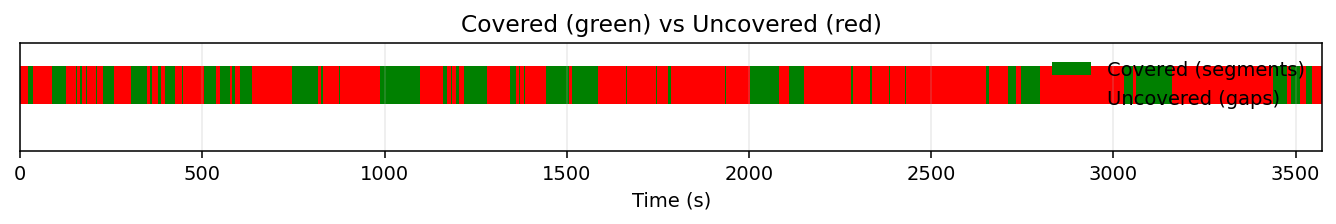

In [21]:
# one entry from your csv_video dict
one_csv, one_vid = next(iter(csv_video.items()))
gaps_csv = (Path(one_vid).parent / "segments" / f"{Path(one_vid).stem}_uncovered_gaps.csv")

plot_segments_vs_gaps_for_video(
    video_path=one_vid,
    gaps_csv_path=str(gaps_csv),
    title="Covered (green) vs Uncovered (red)"
)


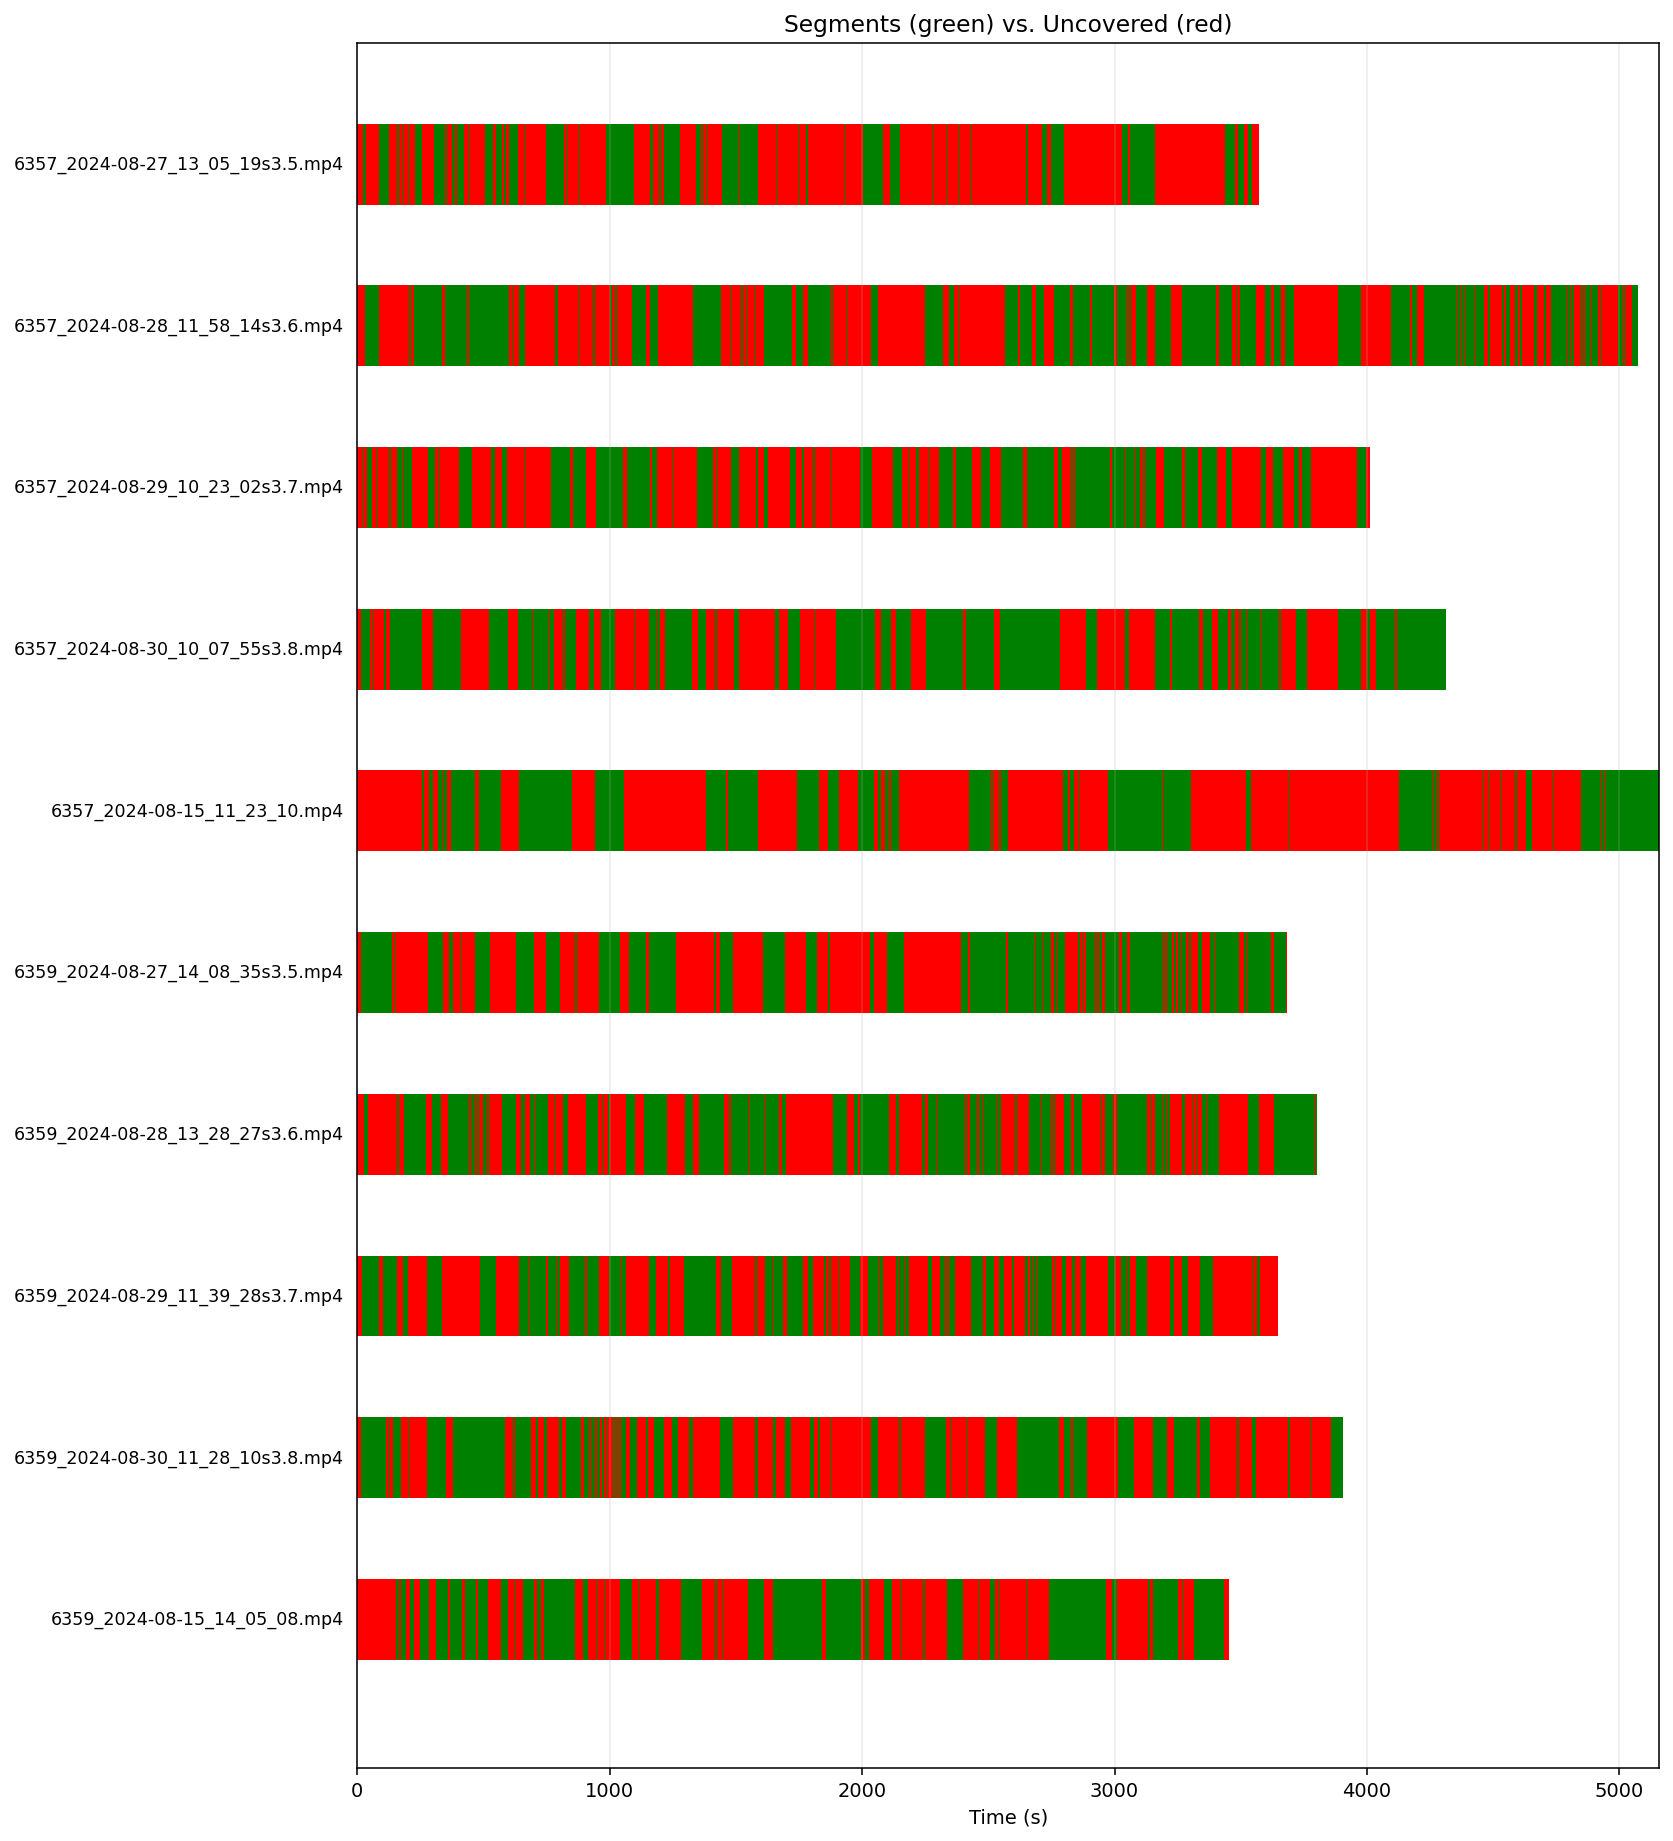

In [22]:
# Show first N videos as stacked bars (one plot, multiple bars)
plot_overview_gantt(csv_video)
